In [ ]:
!pip install -q wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 21.3 MB/s 
     |████████████████████████████████| 145 kB 72.1 MB/s 
     |████████████████████████████████| 181 kB 63.5 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config = {
    "dataset": "MNIST",
    "gpu": "colab",
    "model": "Autoencoder",
    "learning_rate": 0.001,
    "batch_size": 128
}

wandb.init(project="week11_wandb_example", config=config)
wandb.run.name = "wandb example"

wandb: Currently logged in as: yooniversal. Use `wandb login --relogin` to force relogin


In [ ]:
!git clone https://github.com/ultralytics/yolov5 # clone
%cd yolov5
%pip install -qr requirements.txt # install

Cloning into 'yolov5'...
remote: Enumerating objects: 13320, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 13320 (delta 30), reused 38 (delta 29), pack-reused 13277
Receiving objects: 100% (13320/13320), 12.06 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (9277/9277), done.
/content/yolov5
     |████████████████████████████████| 596 kB 31.5 MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import utils

display = utils.notebook_init() # checks
!python train.py --batch 16 --img 416 --epochs 50 --data Raccoon-38/data.yml --weights yolov5s.pt --cache --project yolov5 --name raccoon

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

train_dataset = torchvision.datasets.MNIST(root="MNIST_data/",
                                              train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)
test_dataset = torchvision.datasets.MNIST(root="MNIST_data/",
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)

batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(784, 256)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(256, 784)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

samples = []
for i in range(10):
  samples.append(test_dataset[i][0].view(-1, 784).to(device))
samples = torch.stack(samples).to(device)

epochs = 30

for epoch in range(epochs):
    model.train()
    avg_cost = 0
    total_batch_num = len(train_dataloader)

    for step, batch in enumerate(train_dataloader):
        b_x, b_y = batch
        b_x = b_x.view(-1, 784).to(device)
        z, b_x_hat = model(b_x) # forward prop
        loss = criterion(b_x_hat, b_x) # get cost

        avg_cost += loss / total_batch_num
        optimizer.zero_grad()
        loss.backward() # backward prop
        optimizer.step() # update parameters
        wandb.log({"loss": loss})

    #print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

        # observe differences
        if step % 5 == 0:
            model.eval()
            with torch.no_grad():
                test_z, test_output = model(samples)

            test_output = test_output.detach().cpu().reshape(10,28,28)
            wandb.log({'testset x hat': [wandb.Image(i) for i in test_output]})

YOLOv5 🚀 v6.1-178-g4870064 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.2/78.2 GB disk)
wandb: Currently logged in as: yooniversal. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=Raccoon-38/data.yml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5, name=raccoon, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
Traceback (most recent call last):
  File "train.py", line 667, in <module>
    main(opt)
  File "train.py", line 537, in main
    check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



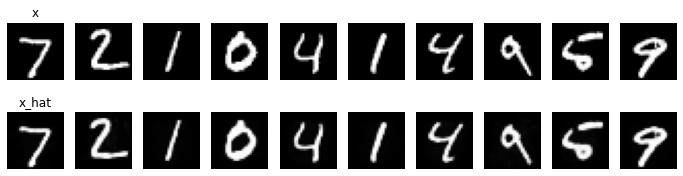

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
test_samples = torch.zeros((10,28,28))
for i in range(10):
  test_samples[i] = test_dataset[i][0]
test_samples = test_samples.view(-1, 784).to(device)
z, test_output = model(test_samples)

fig, ax = plt.subplots(2, 10, figsize=(12,3))
ax[0][0].set_title('x')
ax[1][0].set_title('x_hat')
for i in range(10):
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  ax[0][i].imshow(np.reshape(test_samples[i].detach().cpu(), (28,28)), cmap='gray')
  ax[1][i].imshow(np.reshape(test_output[i].detach().cpu(), (28,28)), cmap='gray')
plt.show()